In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diamonds/diamonds.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics




In [3]:
data=pd.read_csv("../input/diamonds/diamonds.csv")
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
data.shape


(53940, 11)

**DATA PREPROCESSING**

* Data cleaning
* Identifying and removing outliers
* Encoding categorical variables


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


#remove the columns 

In [6]:
data= data.drop( ["Unnamed: 0"],axis=1)
data.describe()  #description happen only in numerical columns

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


**Dropping the value which has min=0..its mean there is no dimention**

In [7]:
data = data.drop(data[data["x"]==0].index)
data = data.drop(data[data["y"]==0].index)
data = data.drop(data[data["z"]==0].index)
data.shape

(53920, 10)

****

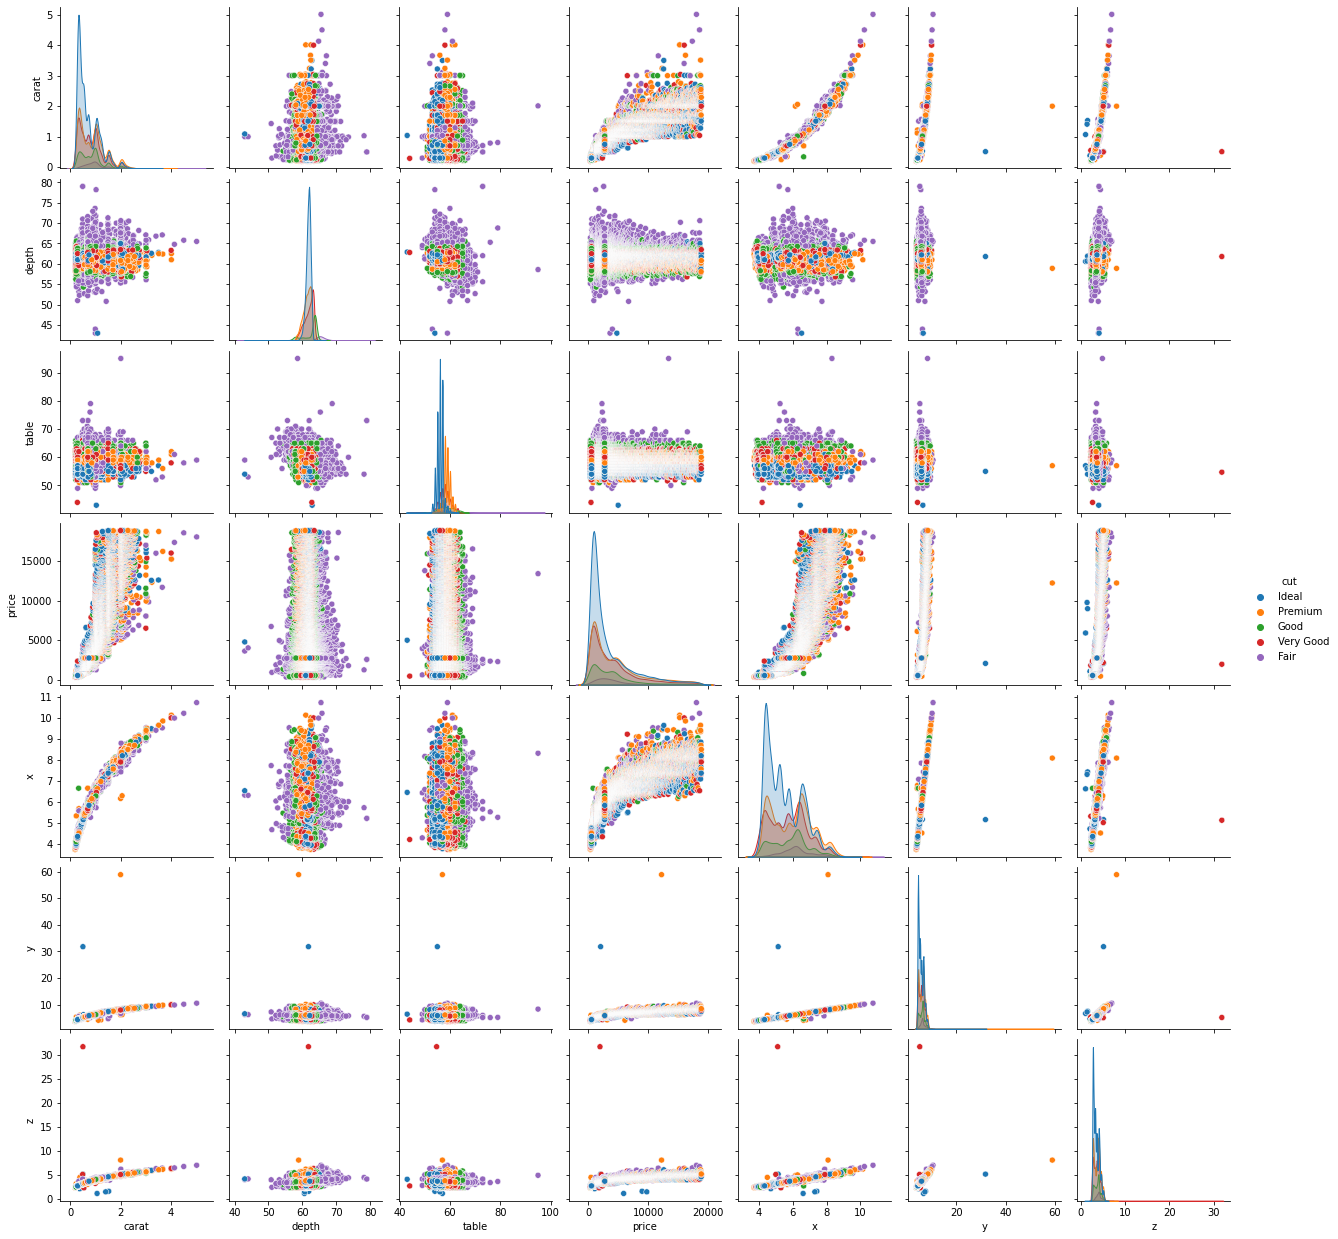

In [8]:
ax = sns.pairplot(data,hue= "cut")

**A few points to notice in these pair plots**

There are some features with daapoint that are far from the rest of the dataset which will affect the outcome of our regression model.
* "y" and "z" have some dimensional outlies in our dataset thst needs to ne eliminated.
* The depth should be capped but we must examine the regression line to besure.
* The Table featured should be capped too.
* Let's have a look at regression plots to get a close look at the outliers.

Text(0.5, 1.0, "regression Line on Price vs 'y'")

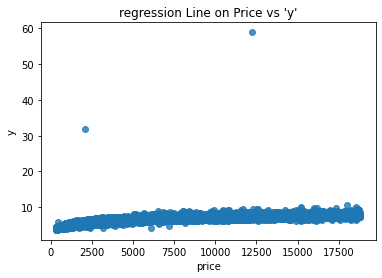

In [9]:
ax = sns.regplot(x="price", y="y",data= data,fit_reg=True)
ax.set_title("regression Line on Price vs 'y'")

Text(0.5, 1.0, "Regression Line on price vs 'z'")

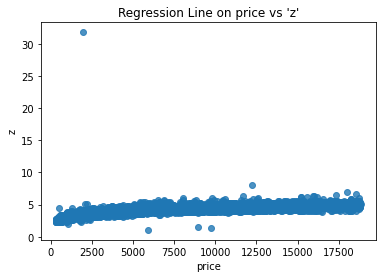

In [10]:
ax=sns.regplot(x="price",y="z",data=data,fit_reg=True)
ax.set_title("Regression Line on price vs 'z'")

Text(0.5, 1.0, 'Regression Line on Price vs depth')

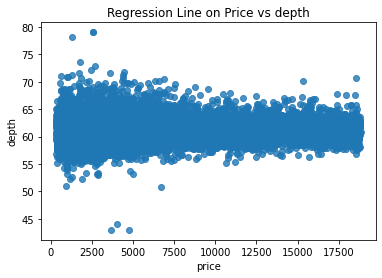

In [11]:
ax=sns.regplot(x="price",y="depth",data=data,fit_reg=True)
ax.set_title("Regression Line on Price vs depth")

Text(0.5, 1.0, 'regression Line on Price and Table')

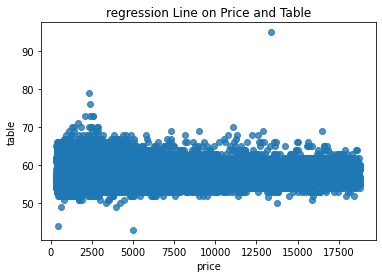

In [12]:
ax=sns.regplot(x="price",y="table",data=data,fit_reg=True)
ax.set_title("regression Line on Price and Table")

**we can clearly spot outliers in these attributes. Next up,we will remove these data points.**

In [13]:
#Dropping the outliers
data=data[(data["depth"]<75)&(data["depth"]>45)]
data=data[(data["table"]<80)&(data["table"]>40)]
data=data[(data["x"]<30)]
data=data[(data["y"]<30)]
data=data[(data["z"]<30)&(data["z"]>2)]
data.shape

(53907, 10)

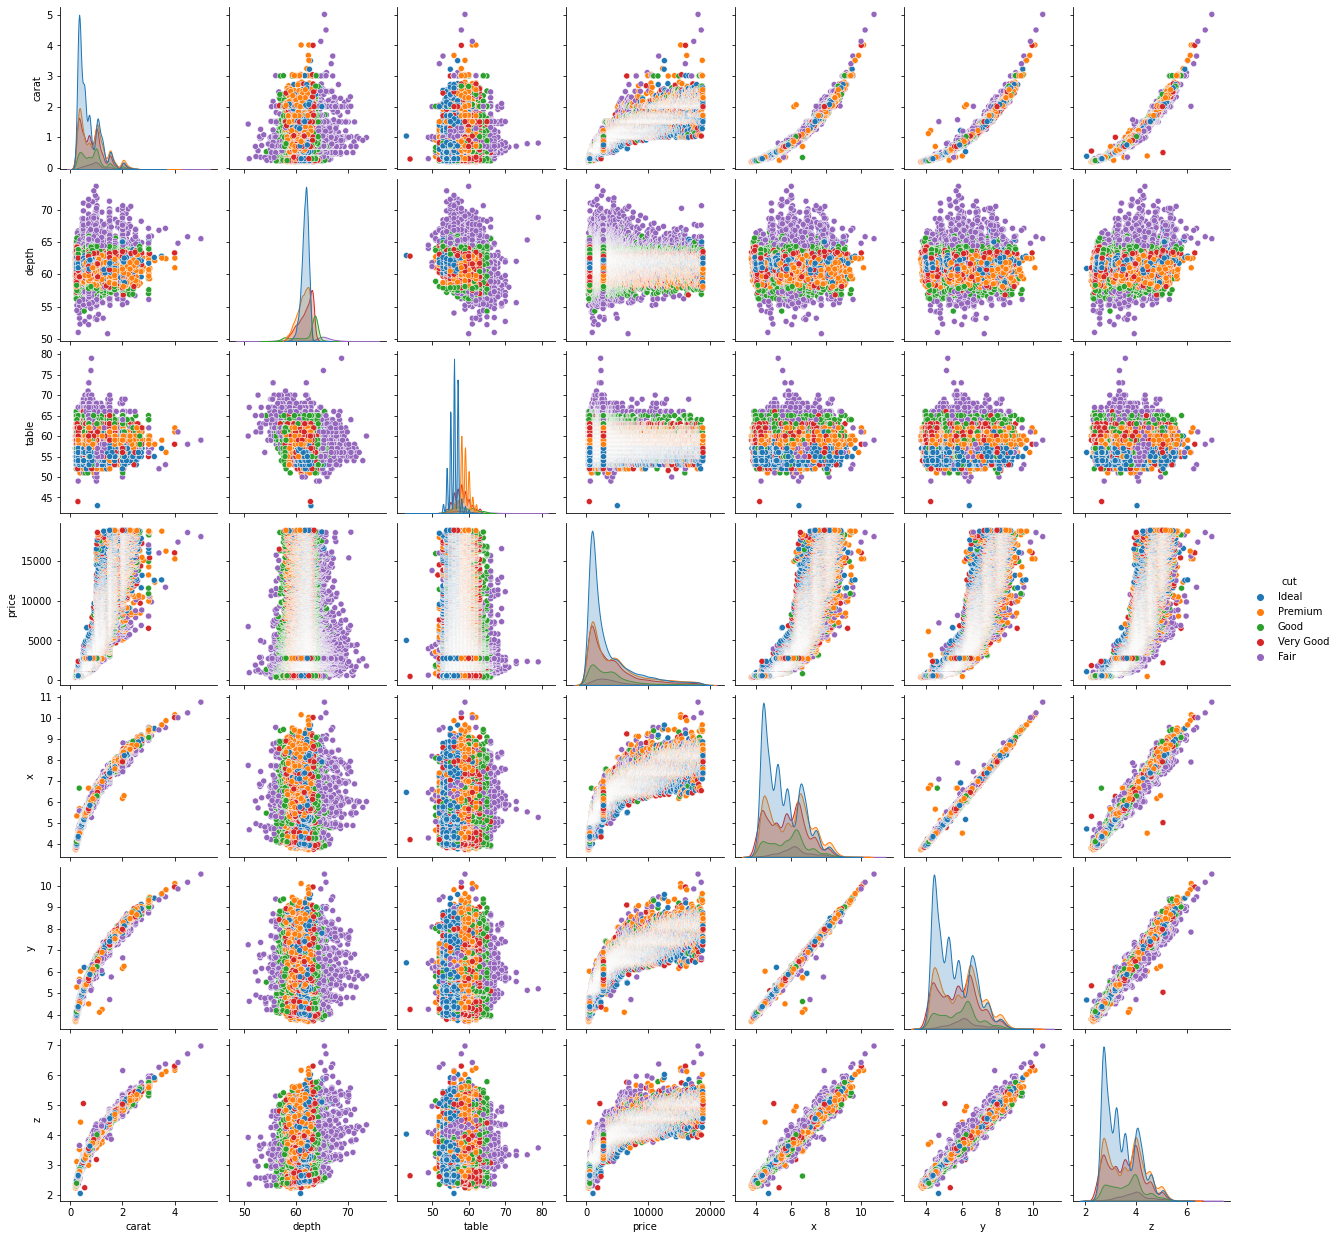

In [14]:
ax=sns.pairplot(data,hue="cut")

**now,we will deal with the categorical variables**

In [15]:
#Get list of categorical variables
s = (data.dtypes=="object")
object_cols=list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['cut', 'color', 'clarity']


**we have three categorical variables .lets have look at them**

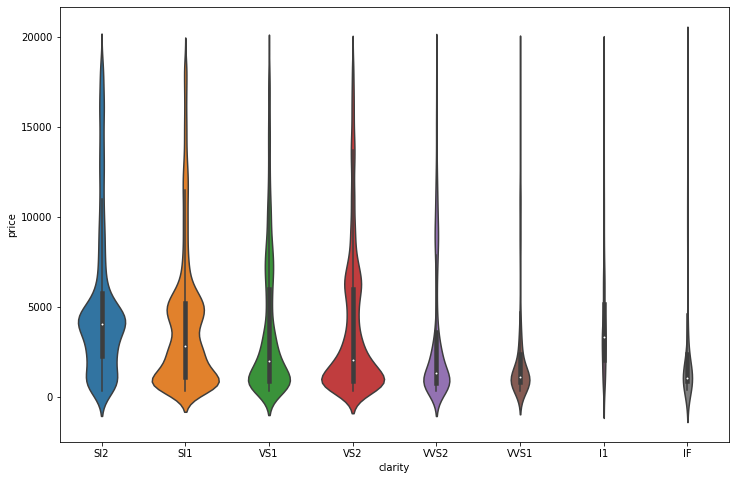

In [16]:
 plt.figure(figsize=(12,8))
ax=sns.violinplot(x="clarity",y="price",data=data,scale="count")

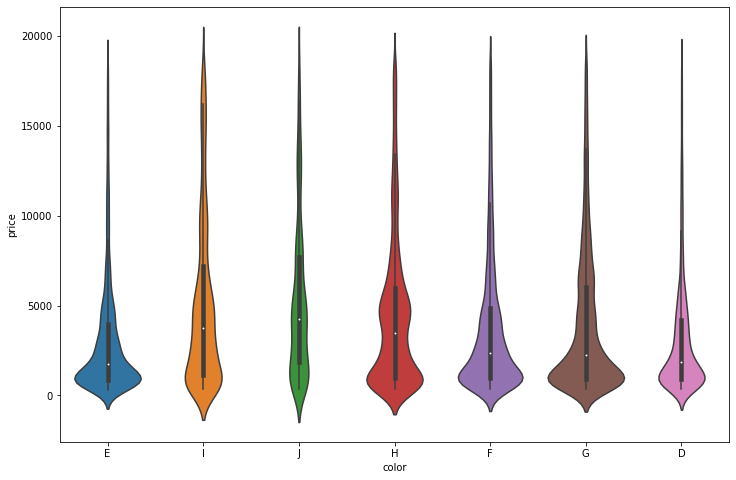

In [17]:
 plt.figure(figsize=(12,8))
ax=sns.violinplot(x="color",y="price",data=data,scale="count")

**Label encoding the data to get rid of object dtype**

In [18]:
#make copy to avoid changing original data
label_data = data.copy()
#Apply label encodet to each column with categorical data
label_encoder=LabelEncoder()
for col in object_cols:
     label_data[col] = label_encoder.fit_transform(label_data[col])
label_data.head()        

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


In [19]:
data.describe()

,carat,depth,table,price,x,y,z
count,53907.000000,53907.000000,53907.000000,53907.000000,53907.000000,53907.000000,53907.000000
mean,0.797628,61.749741,57.455948,3930.584470,5.731463,5.733292,3.539441
std,0.473765,1.420119,2.226153,3987.202815,1.119384,1.111252,0.691434
min,0.200000,50.800000,43.000000,326.000000,3.730000,3.680000,2.060000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5322.000000,6.540000,6.540000,4.040000
max,5.010000,73.600000,79.000000,18823.000000,10.740000,10.540000,6.980000


<AxesSubplot:>

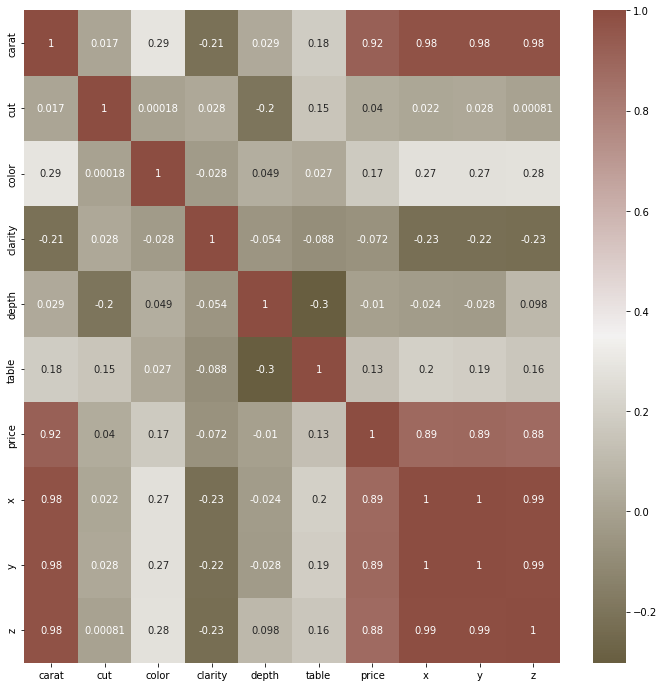

In [20]:
#correlation matrix
cmap = sns.diverging_palette(70,20,s=50,l=40,n=6,as_cmap=True)
corrmat=label_data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap=cmap,annot=True)

**Model building**

steps involved in Model Building

Setting up features and target
* Build a pipeline of standard scalar and model for five different regressors
* Fit all the models on training data
* Get mean of cross-validation on the training set for all the models for negative root mean square error
* Pick the model with the best cross-validation score
* Fit the best model on the training set and get

In [21]:
#make copy to avoid changing original data
label_data = data.copy()
#apply label encoder to each column with categorical data
label_encoder=LabelEncoder()
for col in object_cols:
    label_data[col] = label_encoder.fit_transform(label_data[col])
label_data.head()    


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


In [22]:
# Assigning the featurs as X and trarget as y
X= label_data.drop(["price"],axis =1)
y= label_data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=7)

In [23]:

# Building pipelins of standard scaler and model for varios regressors.

pipeline_lr=Pipeline([("scalar1",StandardScaler()),
                     ("lr_classifier",LinearRegression())])

pipeline_dt=Pipeline([("scalar2",StandardScaler()),
                     ("dt_classifier",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar3",StandardScaler()),
                     ("rf_classifier",RandomForestRegressor())])


pipeline_kn=Pipeline([("scalar4",StandardScaler()),
                     ("rf_classifier",KNeighborsRegressor())])


pipeline_xgb=Pipeline([("scalar5",StandardScaler()),
                     ("rf_classifier",XGBRegressor())])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "XGBRegressor"}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)


In [24]:
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))


LinearRegression: -1348.811824 
DecisionTree: -755.343307 
RandomForest: -546.770231 
KNeighbors: -823.648809 
XGBRegressor: -545.458108 


**Testing the Model with the best score on the test set

In the above scores, XGBClassifier appears to be the model with the best scoring on negative root mean square error. Let's test this model on a test set and evaluate it with different parameters.

**

In [25]:
# Model prediction on test data
pred = pipeline_xgb.predict(X_test)

In [26]:
# Model Evaluation
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))

R^2: 0.9810847980166805
Adjusted R^2: 0.9810721569817172
MAE: 278.0934000996743
MSE: 296738.36462685897
RMSE: 544.7369682946614
